# Tutorial on Bayesian linear regression

**Alfredo Garbuno-Inigo**  
Phd student, University of Liverpool  
Institute for Risk and Uncertainty

In [42]:
%matplotlib inline
from pymc3 import *
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Case study: Admittance to university. 


In [43]:
d = {'dept': ['A','A','B','B','C','C','D','D','E','E','F','F'], 
    'gender': ['male','female','male','female','male','female','male','female','male','female','male','female'], 
    'admit': [512,89,353,17,120,202,138,131,53,94,22,24], 
    'reject': [313,19, 207, 8,205,391 ,279, 244, 138 ,299, 351, 317], 
     'applications': [825,108,560,25,325,593,417,375,191,393,373,341]
    }
df = pd.DataFrame(d)

In [44]:
print 'Number of records: %s' %(df.shape[0])
print 'Number of features: %s' %(df.shape[1])

Number of records: 12
Number of features: 5


In [45]:
df.head(3)

,admit,applications,dept,gender,reject
0,512,825,A,male,313
1,89,108,A,female,19
2,353,560,B,male,207


In [46]:
dfsum = df.sum()[['admit','reject','applications']]
dfsum

admit           1755
reject          2771
applications    4526
dtype: object

# Case study: Admittance to university. 

In [47]:
print 'Acceptance rate: %s' %(np.ceil(100*(dfsum['admit']+0.0)/dfsum['applications']))

Acceptance rate: 39.0


In [48]:
df.groupby('gender').sum().apply(lambda x: (100*x['admit']+0.)/x['applications'], axis=1)

gender
female    30.354223
male      44.518766
dtype: float64

In [49]:
df.groupby('dept').sum()[['admit','reject', 'applications']]

,admit,reject,applications
dept,,,
A,601,332,933
B,370,215,585
C,322,596,918
D,269,523,792
E,147,437,584
F,46,668,714


In [50]:
df.groupby('dept').sum().apply(lambda x: 100.0*x[['admit','reject']]/x['applications'],axis=1)

,admit,reject
dept,,
A,64.415863,35.584137
B,63.247863,36.752137
C,35.076253,64.923747
D,33.964646,66.035354
E,25.171233,74.828767
F,6.442577,93.557423


In [51]:
depts = df.dept.unique()
n_depts = len(depts)
dept_table = dict(zip(depts, range(n_depts)))
dept = df.dept.replace(dept_table).values

dept_table

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [52]:
gender = df.gender.replace(dict(zip(df.gender.unique(), range(2))))

dict(zip(df.gender.unique(), range(2)))

{'female': 1, 'male': 0}

## Pooled model

$$ \begin{align}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha & \sim \mathcal{N}(0,1)
\end{align}
$$ 

In [53]:
with Model() as pooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e1, shape=2)
    # Linear model
    theta = beta[0] + beta[1]*gender

    # This just computes the link function, no posterior sampling
    # p = pm.invlogit(theta)
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [54]:
n_samples = 3000
n_opt = 20000
n_warm = 1000

with pooled_model:
    pooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 451.9:  49%|████▊     | 9718/20000 [00:01<00:01, 6940.29it/s] 
Convergence archived at 10000
Interrupted at 10,000 [50%]: Average Loss = 557.58
100%|██████████| 4000/4000 [00:08<00:00, 495.53it/s]


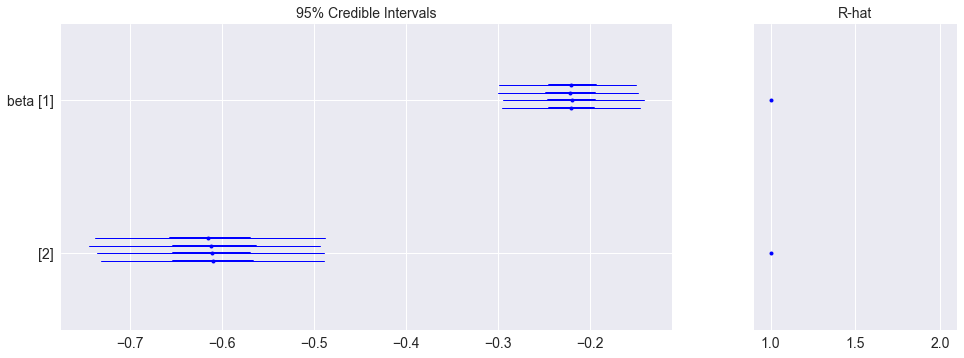

In [55]:
plt.figure(figsize=(15, 5))
forestplot(pooled_trace[1000:], varnames = ['beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123432950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1224abd10>]], dtype=object)

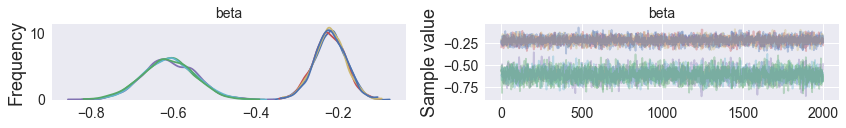

In [56]:
plt.figure(figsize=(15, 5))
pm.traceplot(pooled_trace[1000:], varnames = ['beta'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12237d150>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12446ae90>], dtype=object)

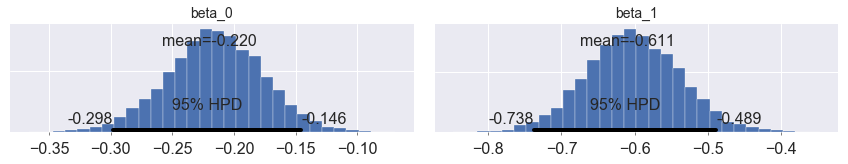

In [57]:
plt.figure(figsize=(15, 5))
pm.plot_posterior(pooled_trace[1000:], varnames = ['beta'])

In [58]:
dfsort = df.sort_values(['dept','gender'],ascending=[True, False])
pobs = 1.*dfsort['admit']/dfsort['applications']

phat = pd.Series(pooled_trace[n_warm:]['p'].mean(axis = 0))
pstd = np.sqrt(phat*(1 - phat)/dfsort.applications)

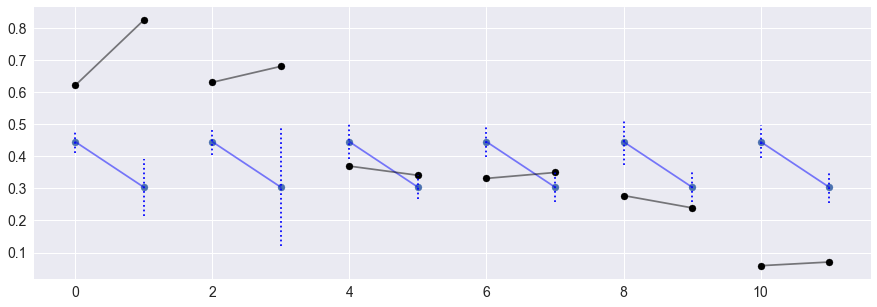

In [59]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat[i], phat[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

## Unpooled model

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(0,1) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\
\end{array}
\end{align}
$$ 

In [60]:
with Model() as unpooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0)
    alpha = Normal('alpha', 0, sd = 1e0, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta * gender
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [61]:
with unpooled_model:
    unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 69.982:  62%|██████▏   | 12356/20000 [00:01<00:01, 6417.95it/s]
Convergence archived at 12700
Interrupted at 12,700 [63%]: Average Loss = 227.14
100%|██████████| 4000/4000 [00:12<00:00, 321.22it/s]


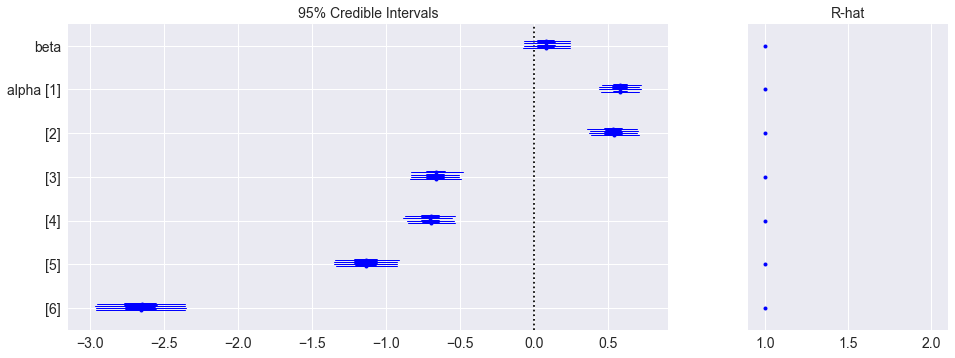

In [62]:
plt.figure(figsize=(15, 5))
forestplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1250ca8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12202bd50>]], dtype=object)

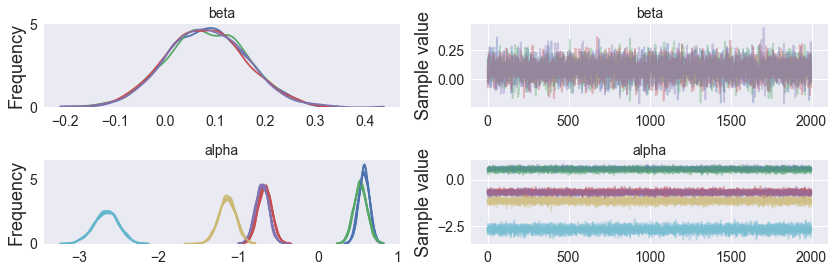

In [63]:
plt.figure(figsize=(15, 5))
pm.traceplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'])

In [64]:
phat_unpooled = pd.Series(unpooled_trace[n_warm:]['p'].mean(axis = 0))
pstd_unpooled = np.sqrt(phat_unpooled*(1 - phat_unpooled)/dfsort.applications)

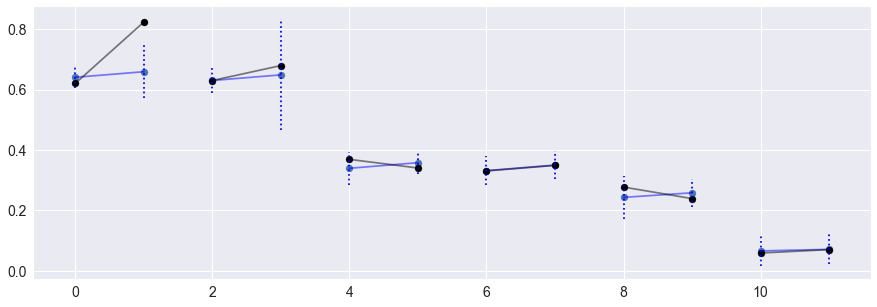

In [65]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat_unpooled)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_unpooled, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_unpooled[i], phat_unpooled[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

## Hierarchical: *varying intercept*

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(\mu_a,\sigma_a) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\mu_a & \sim \mathcal{N}(0,10) \\
\sigma_a & \sim \text{HalfCauchy}(0,2)
\end{array}
\end{align}
$$ 

In [66]:
with Model() as hierarchical:
    # Priors in highest hierarchy
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[dept] + beta * gender
    p = pm.Deterministic('p', pm.invlogit(theta))
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [67]:
with hierarchical:
    hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 72.303:  69%|██████▉   | 13802/20000 [00:02<00:01, 4923.37it/s]
Convergence archived at 14000
Interrupted at 14,000 [70%]: Average Loss = 218.32
100%|██████████| 4000/4000 [00:15<00:00, 264.38it/s]


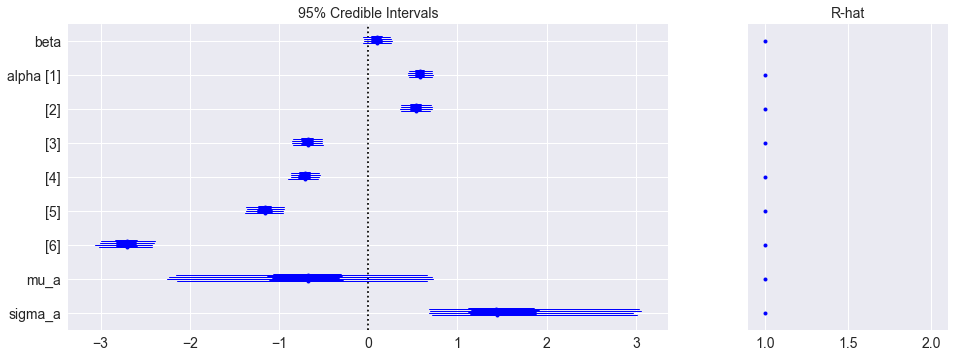

In [68]:
plt.figure(figsize=(15, 5))
forestplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha', 'mu_a', 'sigma_a'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1287703d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1265eda50>]], dtype=object)

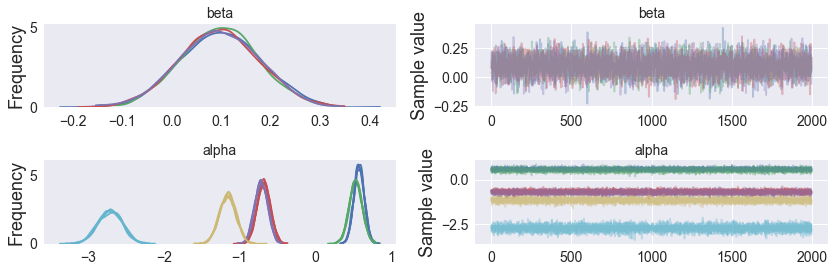

In [69]:
plt.figure(figsize=(15, 5))
pm.traceplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1268de450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126131590>]], dtype=object)

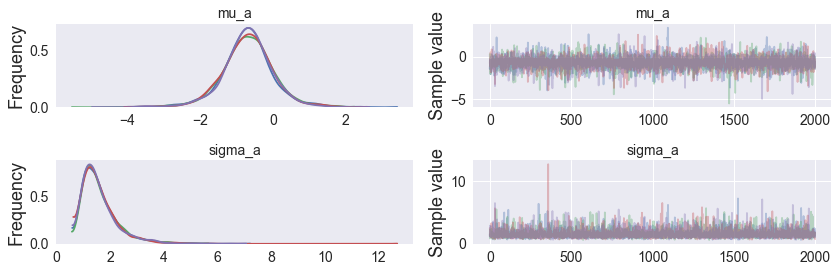

In [70]:
plt.figure(figsize=(15, 5))
pm.traceplot(hierarchical_trace[1000:], varnames = ['mu_a', 'sigma_a'])

In [71]:
phat_hierarchical = pd.Series(hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_hierarchical = np.sqrt(phat_hierarchical*(1 - phat_hierarchical)/dfsort.applications)

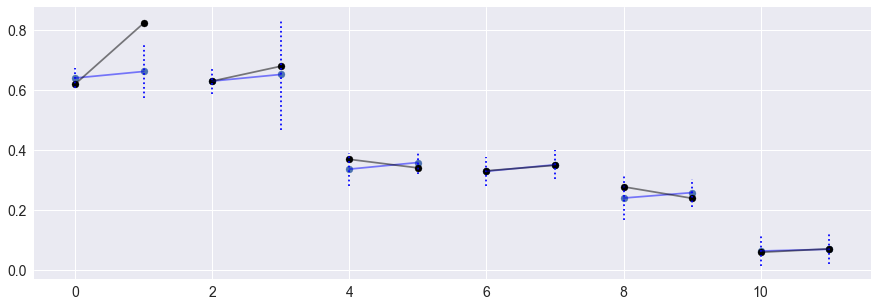

In [72]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat_hierarchical)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_hierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_hierarchical[i], phat_hierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

## Full hierarchical: *Varying slope and intercept*

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta_{\text{DEPT}[i]} \, m_i \\
\beta_{\text{DEPT}} & \sim \mathcal{N}(\mu_b,\sigma_b) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\alpha_{\text{DEPT}} & \sim \mathcal{N}(\mu_a,\sigma_a) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\mu_a & \sim \mathcal{N}(0,10) \\
\mu_b & \sim \mathcal{N}(0,10) \\
\sigma_a & \sim \text{HalfCauchy}(0,2)\\
\sigma_b & \sim \text{HalfCauchy}(0,2)
\end{array}
\end{align}
$$ 

In [73]:
with Model() as full_hierarchical:
    # Priors in highest hierarchy
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = HalfCauchy('sigma_a', 5)
    mu_b = Normal('mu_b', mu=0., sd=1e1)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    # Priors in regression coefficients
    beta = Normal('beta', mu_b, sd=sigma_b, shape = n_depts)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[dept] + beta[dept] * gender
    p = pm.Deterministic('p', pm.invlogit(theta))  
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [74]:
n_samples = 5000
n_warm = 2000

with full_hierarchical:
    full_hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 76.152:  70%|██████▉   | 13990/20000 [00:03<00:01, 4142.07it/s]
Convergence archived at 14300
Interrupted at 14,300 [71%]: Average Loss = 210.65
100%|█████████▉| 6989/7000 [00:48<00:00, 129.92it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 0 contains 27 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 7000/7000 [00:48<00:00, 144.64it/s]
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 30 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning:

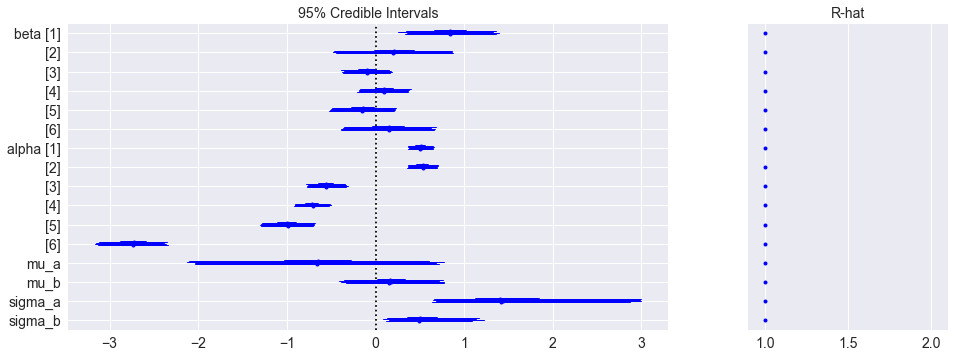

In [75]:
plt.figure(figsize=(15, 5))
forestplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha', 'mu_a', 'mu_b', 'sigma_a', 'sigma_b'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12db3fa90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a95eb50>]], dtype=object)

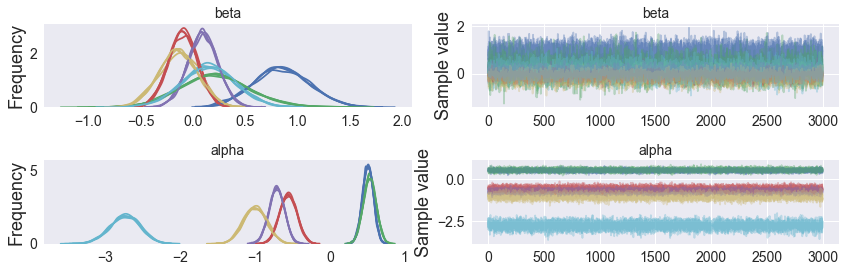

In [76]:
plt.figure(figsize=(15, 5))
traceplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ab6dd50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12d7acd90>]], dtype=object)

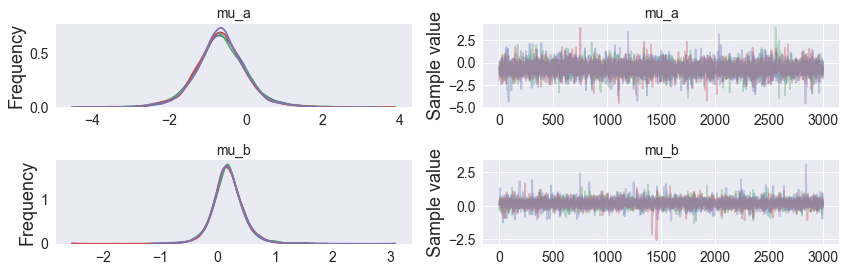

In [77]:
plt.figure(figsize=(15, 5))
traceplot(full_hierarchical_trace[n_warm:], varnames = ['mu_a', 'mu_b'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e63d790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12e482e90>]], dtype=object)

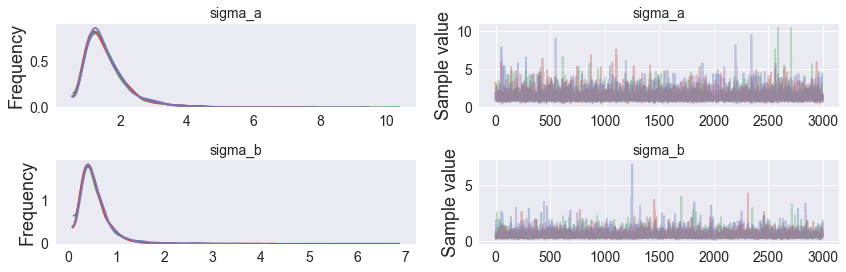

In [78]:
plt.figure(figsize=(15, 5))
traceplot(full_hierarchical_trace[n_warm:], varnames = ['sigma_a', 'sigma_b'])

In [79]:
phat_fhierarchical = pd.Series(full_hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_fhierarchical = np.sqrt(phat_fhierarchical*(1 - phat_fhierarchical)/dfsort.applications)

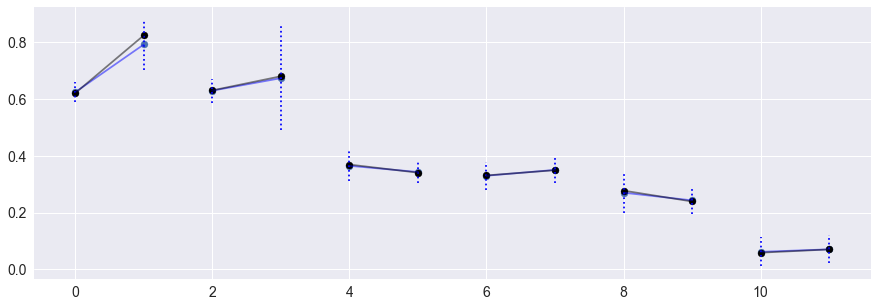

In [80]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat_fhierarchical)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_fhierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_fhierarchical[i], phat_fhierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

In [81]:
traces = [pooled_trace, unpooled_trace, hierarchical_trace, full_hierarchical_trace]
models = [pooled_model, unpooled_model, hierarchical, full_hierarchical]
models_list = ['pooled', 'unpooled', 'var_interc', 'var_intslop']

for t, m, n in zip(traces, models, models_list):
    print '%s  \t : %s' %(n, pm.stats.dic(t,m))

pooled  	 : 869.390878295
unpooled  	 : 126.452655703
var_interc  	 : 137.83325954
var_intslop  	 : 146.859705959


In [85]:
pm.stats.compare(traces, models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
3,88.8935,5.86137,0,0.999895,4.09164,0,0
2,108.515,9.39955,19.6217,5.4847e-05,15.7074,13.9825,0
1,108.683,9.39155,19.7897,5.04279e-05,15.9846,14.2745,0
0,993.984,112.246,905.09,2.89829e-197,315.432,315.933,0
